In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, clone
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape # 70k images, 784 features (28x28 pixels)

(70000, 784)

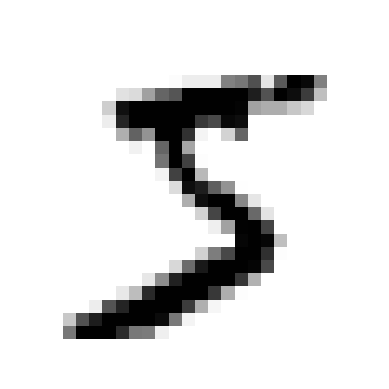

In [4]:
some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28, 28) # create image from 1D array
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# label
print(y[0])
print(type(y[0]))

5
<class 'str'>


In [6]:
# convert string to int
y = y.astype(np.uint8)

In [7]:
# train test split
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# binary classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)


sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit]) # predict the digit 5 (True is 5, False is not 5)

C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [10]:
# cross validation check
score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(score)

[0.95035 0.96035 0.9604 ]


In [11]:
# cross validation check with custom implementation
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
# Dummy classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

score = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(score) # [0.91125 0.90855 0.90915]

# It's means only 10% of the data is 5, so if you always guess that the image is not 5, you will be right 90% of the time.

[0.91125 0.90855 0.90915]


In [13]:
# confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix = pd.crosstab(y_train_5, y_train_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
# True Negative: 53892, False Positive: 687
# False Negative: 1891, True Positive: 3530

# accuracy = TN + TP / (TN + FP + FN + TP) = 53892 + 3530 / (53892 + 687 + 1891 + 3530) = 0.9502 %
# precision = TP / (TP + FP) = 3530 / (3530 + 687) = 0.84  
# recall = TP / (TP + FN) = 3530 / (3530 + 1891) = 0.65 %
# f1 = 2 * (precision * recall) / (precision + recall) = 2 * (0.84 * 0.65) / (0.84 + 0.65) = 0.74 % 

Predicted  False  True 
Actual                 
False      53892    687
True        1891   3530


In [14]:
# precision and recall ratio
# we cannot change the threshold of the model, but we can change the threshold of the decision function
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0 # default threshold
y_some_digit_pred = (y_scores > threshold) # True
print(y_some_digit_pred)

# make the threshold higher
threshold = 8000

y_some_digit_pred = (y_scores > threshold) # False
print(y_some_digit_pred)


[2164.22030239]
[ True]
[False]


C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


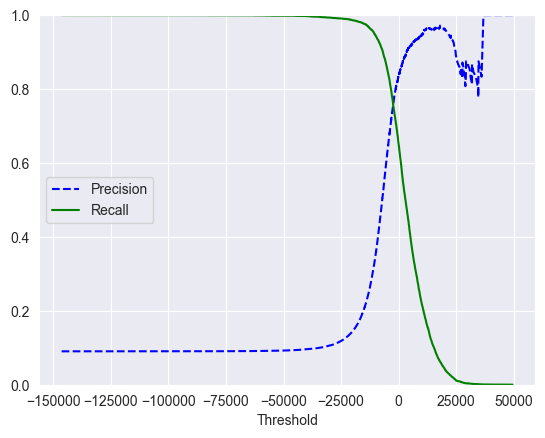

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [16]:

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('Threshold for 90 % accuracy is: ', threshold_90_precision)

x_train_pred_90 = (y_scores >= threshold_90_precision)

pre_score = precision_score(y_train_5, x_train_pred_90)
rec_score = recall_score(y_train_5, x_train_pred_90)

print(pre_score) # 0.90 % precision increased
print(rec_score) # 0.48 %  recall decreased

Threshold for 90 % accuracy is:  3370.0194991439557
0.9000345901072293
0.4799852425751706


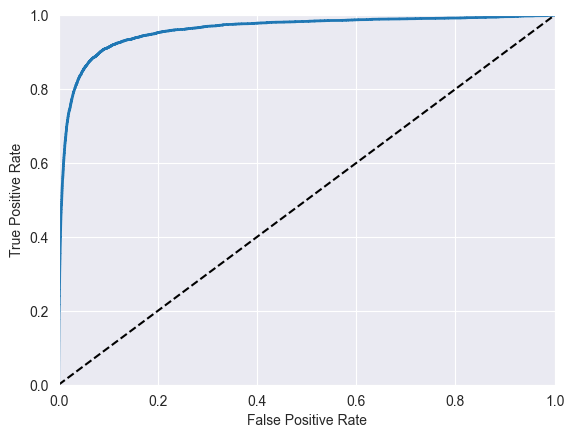

In [17]:
# ROC curve ( indicate the true positive rate against the false positive rate)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) # plot the curve
    plt.plot([0, 1], [0, 1], 'k--') # plot the diagonal
    plt.axis([0, 1, 0, 1]) # set the axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
# The more recall of model, the more false positive rate

In [18]:
# ROC AUC score

# AUC score is the area under the ROC curve
roc_auc_score = roc_auc_score(y_train_5, y_scores)
print(roc_auc_score) # 0.96 
# Good model has ROC AUC score close to 1, bad model has ROC AUC score close to 0.5

0.9604938554008616


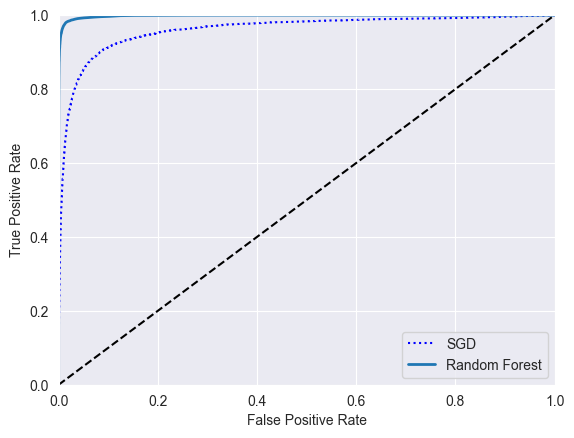

In [19]:
# Random Forest Classifier model for comparison
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [23]:
# ROC AUC score
roc_auc_score(y_train_5, y_scores_forest) # 0.99

0.9983436731328145

In [24]:
# Multiclass classification

# SGD, RandomForest, and Naive Bayes classifiers can be used for multiclass classification
# But SVM, Linear classifiers, and Neural Networks are binary classifiers it can be used for multiclass classification using OvR or OvO strategy

# SVC bad for large datasets, so we use SGDClassifier

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5 (so it's multiclass classification)

[5]


C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [26]:
prediction = svm_clf.predict([some_digit]) # predict the digit 5
# SVC classifier trained 10 binary classifiers, get their decision scores for the image, and selected the class with the highest score
digit_scores = svm_clf.decision_function([some_digit])
print(digit_scores)
print(np.argmax(digit_scores)) # 5
print(prediction)
len(svm_clf.classes_) # 10 classes

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[5]


C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


10

In [ ]:
# Using OvR strategy
ovr_clf = OneVsRestClassifier(SVC())

ovr_clf.fit(X_train, y_train)

prediction = ovr_clf.predict([some_digit])  
print(prediction) # 5

len(ovr_clf.estimators_) # 10

In [27]:
# Training SGDClassifier
sgd_clf.fit(X_train, y_train)

prediction = sgd_clf.predict([some_digit])
print(prediction) # predicted - 3

[3]


C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [28]:
sgd_clf.decision_function([some_digit]) # 3

score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print(score) # 
print(score.mean()) #

C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


[0.87365 0.85835 0.8689 ]
0.8669666666666668


In [ ]:
# To improve the accuracy, we can scale the inputs
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
score = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(score) # 
print(score.mean()) #

In [ ]:
# Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # fill the diagonal with 0
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # plot the matrix
plt.show()

In [ ]:
# Draw the digit 3 and 5

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.values.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")
    
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.save_fig("error_analysis_digits_plot")
plt.show()

In [ ]:
# Multilabel classification
y_train_large = (y_train >= 7) # is the digit large?
y_train_odd = (y_train % 2 == 1) # is the digit odd?

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit]) # [False, True] 3 is not large and odd

In [ ]:
# Evaluate the model
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # F1 score
# If we have more large digits, we can set the weight of the large digits to be higher
f1_score(y_multilabel, y_train_knn_pred, average="weighted") # F1 score (adjust weight)

In [ ]:
# Multioutput classification

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

noise = np.random.randint(0, 100, (len(X_train), 784)) # generate random noise
X_train_mod = X_train + noise # add noise to the training set
noise = np.random.randint(0, 100, (len(X_test), 784)) # generate random noise
X_test_mod = X_test + noise # add noise to the test set
y_train_mod = X_train # target is the original image
y_test_mod = X_test # target is the original image

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[0]]) # clean the image
plot_digits(clean_digit)

#### Extra material

1. Improve the model 